Let’s import the libraries that we are going to use for data manipulation, visualization, training the model, etc.

In [1]:
# import library to ploting
# import matplotlib.ticker as tkr
import matplotlib.pyplot as plt
# import urllib.request
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import pandas as pd
from math import sqrt
# pd.set_option('display.float_format', lambda x: '%.4f' % x)
%matplotlib inline
import numpy as np
# avoid alert
import warnings
warnings.filterwarnings('ignore')
# import datetime as dt
from scipy import stats
# Import library to preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
# performace metrics libray
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# select the GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1' # SET A SINGLE GPU
# import library modules keras and tensorflow
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from tensorflow import keras
from keras import optimizers
import keras
from keras.layers import *
import tensorflow as tf
from keras.models import Sequential
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.layers import Conv1D, MaxPool2D, Flatten, Dropout, CuDNNGRU, CuDNNLSTM
from keras.layers import Dense, LSTM, GRU, Dropout, Bidirectional, BatchNormalization
import matplotlib.image  as mpimg
from keras.models import Model, Input
from keras import regularizers
from keras.callbacks import TensorBoard, ReduceLROnPlateau, EarlyStopping

Using TensorFlow backend.


LSTM 

In [2]:
# load the dataset
dataset_throughput = pd.read_csv('../../file/dataset_throughput.csv', header=0, low_memory=True)

In [3]:
dataset_throughput.set_index('timestamp', inplace=True)
# dataset_throughput.sort_values('timestamp', inplace=True)

In [4]:
# swap some columns positions
columnsTitles = ['connect_time','request_ticks','year','month','hour','day','weekday','minute','second','iteration','delta_sys_time','delta_user_time','rate','received','delay','tcp_mean_wind','downthpt']
dataset_throughput = dataset_throughput.reindex(columns=columnsTitles)

Normalization

In [5]:
dataset = dataset_throughput.iloc[:, 4:]
dataset = dataset.astype('float32')
print(dataset.shape)
TRAIN_SIZE = int(len(dataset) * 0.60) # 60% train set
VALID_SIZE = int(len(dataset) * 0.80) # 20% valid and test set

(12245155, 13)


In [6]:
def one_hot_encoder(df, col):
    onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
    for c in col:        
        v = df[c].values
        v = np.reshape(v, (-1,1))
        v = onehot_encoder.fit_transform(v)
        df[c] = v
    return df

In [7]:
# here we going to normalize the categorical features with One Hot Encoder
col = ['hour', 'day', 'weekday', 'minute', 'second', 'iteration']
dataset = one_hot_encoder(dataset, col)

In [8]:
dataset_train = dataset.iloc[:TRAIN_SIZE, :]
print('Training Set: ', dataset_train.shape)

dataset_val = dataset.iloc[TRAIN_SIZE:VALID_SIZE, :]
print('Validation Set: ', dataset_val.shape)

dataset_test = dataset.iloc[VALID_SIZE:, :]
print('Test Set: ', dataset_test.shape)

Training Set:  (7347093, 13)
Validation Set:  (2449031, 13)
Test Set:  (2449031, 13)


In [ ]:
# We are going to use StandardScaler from sklearn library to scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
# scaler = StandardScaler()
train_arr = scaler.fit_transform(dataset_train)
val_arr = scaler.transform(dataset_val)
test_arr = scaler.transform(dataset_test)

In [ ]:
# split into input and outputs
# train_X, train_y = train_arr[:, :-1], train_arr[:, -1]
# val_X, val_y = val_arr[:, :-1], val_arr[:, -1]
# test_X, test_y = test_arr[:, :-1], test_arr[:, -1]

In [ ]:
# reshape input to be 3D [samples, timesteps, features]
# train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
# val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
# test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
# print(train_X.shape, train_y.shape, val_X.shape, val_y.shape)

In [9]:
def transform_dataset(dataset, look_back=1):
    data, label = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        data.append(a)
        label.append(dataset[i + look_back,0])
    return np.array(data), np.array(label)

In [ ]:
# time window 
# time_steps = 5
# X_train, y_train = transform_dataset(train_arr, time_steps)
# X_test, y_test = transform_dataset(val_arr, time_steps)
# X_val, y_val = transform_dataset(test_arr, time_steps)
# print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

In [11]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)        
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

Scaling the with Data RobustScaler

In [10]:
# normalization with downthpt!
f_columns = ['hour','day','weekday','minute','second',
             'iteration','delta_sys_time','delta_user_time',
             'rate','received','delay','tcp_mean_wind']

scaler_transf = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))
# f_transformer = StandardScaler()
# thrput_transformer = StandardScaler()

scaler_transf = scaler_transf.fit(dataset_train[f_columns].to_numpy())
scaler_target = scaler_target.fit(dataset_train[['downthpt']])

dataset_train.loc[:, f_columns] = scaler_transf.transform(dataset_train[f_columns].to_numpy())
dataset_train['downthpt'] = scaler_target.transform(dataset_train[['downthpt']])

dataset_val.loc[:, f_columns] = scaler_transf.transform(dataset_val[f_columns].to_numpy())
dataset_val['downthpt'] = scaler_target.transform(dataset_val[['downthpt']])

dataset_test.loc[:, f_columns] = scaler_transf.transform(dataset_test[f_columns].to_numpy())
dataset_test['downthpt'] = scaler_target.transform(dataset_test[['downthpt']])

In [12]:
train_arr = dataset_train.values
val_arr = dataset_val.values
test_arr = dataset_test.values

In [16]:
time_steps = 5
# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train_arr, train_arr[:, -1], time_steps)
X_val, y_val = create_dataset(val_arr, val_arr[:, -1], time_steps)
X_test, y_test = create_dataset(test_arr, test_arr[:, -1], time_steps)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(7347088, 5, 13) (7347088,) (2449026, 5, 13) (2449026,)


### Modeling my LSTM with API Keras

In [19]:
def model_lstm(train):
    input_x = Input(shape=(train.shape[1], train.shape[2]))
    # RandomNormal = initializers.RandomNormal(mean=0.5, stddev=0.05, seed=None)
    x = LSTM(units=32, activation='tanh', return_sequences=True)(input_x)
    x = LSTM(units=32, activation='tanh', return_sequences=False)(x)
    # x = LSTM(units=16, activation='tanh', return_sequences=False)(x)
    x = Dropout(rate=0.1)(x)
    x = Dense(units=1)(x)
    model = Model(inputs=input_x, outputs=x)
    return model

Bidirectional

In [17]:
def model_lstm_bid(train):
    input_x = Input(shape=(train.shape[1], train.shape[2]))
    x = Bidirectional(LSTM(units=64, activation='relu'))(input_x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.1)(x)
    x = Dense(units=1)(x)
    model = Model(inputs=input_x, outputs=x)
    return model

In [20]:
def compile_fit(train, target_train, test, target_test):
    model = model_lstm(train)
    model.summary()
    sgd_0 = optimizers.SGD(lr=0.05, decay=1e-5, momentum=0.9)
    sgd_1 = optimizers.SGD(lr=0.5, decay=0, nesterov=True)
    model.compile(loss='mean_squared_error', optimizer=sgd_1, metrics=['mean_absolute_error', 'mean_squared_error'])
    history = model.fit(train, target_train,
                        epochs=4, 
                        batch_size=64, 
                        validation_data=(test, target_test), 
                        shuffle=False,
                        verbose=1)
    return history, model

In [21]:
hist, model = compile_fit(X_train, y_train, X_val, y_val)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5, 13)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 32)             5888      
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 14,241
Trainable params: 14,241
Non-trainable params: 0
_________________________________________________________________

Train on 7347088 samples, validate on 2449026 samples
Epoch 1/4
7347088/7347088 [==============================] - 338s 

In [ ]:
yhat = model.predict(test_X)
val_X = val_X.reshape((val_X.shape[0], val_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, val_X), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
val_y = val_y.reshape((len(val_y), 1))
inv_y = np.concatenate((val_y, val_X), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

# calculate MAE
mae = sqrt(mean_absolute_error(inv_y, inv_yhat))
print('Test MAE: %.3f' % mae)

In [22]:
# make predictions whith test set with
y_pred = model.predict(X_test)

In [25]:
y_train_inv = scaler_target.inverse_transform(y_train.reshape(1,-1))

In [40]:
y_test_inv = scaler_target.inverse_transform(y_test.reshape(1, -1))

In [41]:
y_pred_inv = scaler_target.inverse_transform(y_pred)

In [42]:
# calculate MAE
mae = sqrt(mean_absolute_error(y_test_inv.flatten(), y_pred_inv.flatten()))
print('Test MAE: %.3f' % mae)

Test MAE: 14.822


In [45]:
# calculate MAE
mse = sqrt(mean_squared_error(y_test_inv.flatten(), y_pred_inv.flatten()))
print('Test MSE: %.3f' % mse)

Test MSE: 468.613


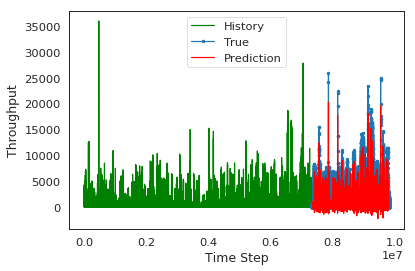

In [46]:
def plot_prediction(train, train_inv, test, test_inv, pred_inv):
    plt.plot(np.arange(0, len(train)), train_inv.flatten(), 'g', label="History")
    plt.plot(np.arange(len(train), len(train) + len(test)), test_inv.flatten(), marker='.', label="True")
    plt.plot(np.arange(len(train), len(train) + len(test)), pred_inv.flatten(), 'r', label="Prediction")
    plt.ylabel('Throughput')
    plt.xlabel('Time Step')
    plt.legend()
    # plt.savefig(os.path.join('./plots', 'prediction.eps'))
    plt.show();
plot_prediction(y_train, y_train_inv, y_test, y_test_inv, y_pred_inv)

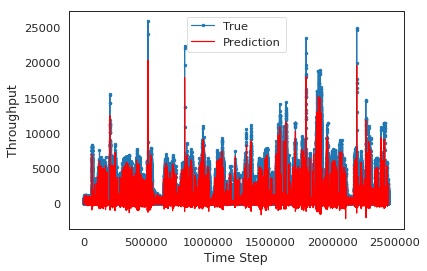

In [47]:
def plot_prediction_(pred_inv, test_inv):
    plt.plot(test_inv.flatten(), marker='.', label="True")
    plt.plot(pred_inv.flatten(), 'r', label="Prediction")
    plt.ylabel('Throughput')
    plt.xlabel('Time Step')
    plt.legend()
    # plt.savefig(os.path.join('./plots', 'prediction_detail.eps'))
    plt.show();
plot_prediction_(y_pred_inv, y_test_inv)

In [ ]:
# plot da perda do modelo

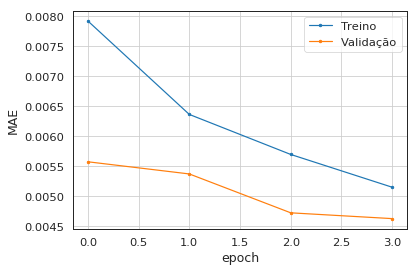

In [37]:
def plot_history_mae(history):
    # plot metrics
    plt.plot(history.history['mean_absolute_error'], marker='.')
    plt.plot(history.history['val_mean_absolute_error'], marker='.')
    plt.ylabel('MAE')
    plt.xlabel('epoch')
    plt.grid()
    plt.legend(['Treino', 'Validação'], loc='best')
    # plt.savefig(os.path.join('./../plots', 'mae.eps'))
    plt.show()
    
plot_history_mae(hist)

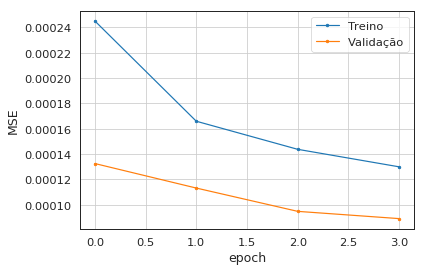

In [38]:
def plot_history_mse(history):
    # plot metrics
    plt.plot(history.history['mean_squared_error'], marker='.')
    plt.plot(history.history['val_mean_squared_error'], marker='.')
    plt.ylabel('MSE')
    plt.xlabel('epoch')
    plt.grid()
    plt.legend(['Treino', 'Validação'], loc='best')
    # plt.savefig(os.path.join('./../plots', 'mse.eps'))
    plt.show()
    
plot_history_mse(hist)

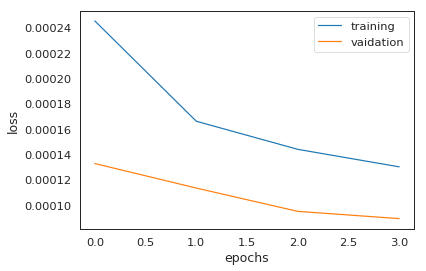

In [39]:
def plot_history_loss(history):
    #-----------------------------------------------------------
    # Retrieve a list of list results on training and test data
    # sets for each training epoch
    #-----------------------------------------------------------
    # loss=history.history['loss']
    # val_loss=history.history['val_loss']
    # epochs=range(len(loss)) # Get number of epochs
    
    plt.plot(history.history['loss'], label='training')
    plt.plot(history.history['val_loss'], label='vaidation')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend();
    # plt.savefig(os.path.join('./plots', 'loss.eps'))

    #------------------------------------------------
    # Plot training and validation loss per epoch
    #------------------------------------------------
    # plt.plot(epochs, loss, val_loss)
    # plt.title('Training loss')
    # plt.xlabel("Epochs")
    # plt.ylabel("Loss")
    # plt.legend(["Loss"])
    
plot_history_loss(hist)